## Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

## User/portfolio data load

In [4]:
user_df = pd.read_csv("data/synthetic_user_data.csv")
portfolio_df = pd.read_excel("data/portfolio_data.xlsx")


## Pair user/portfolio pairs together (took 30 seconds to complete)

In [ ]:
# --- Create all possible user-portfolio pairs ---
# For each user and each portfolio, calculate how well the portfolio fits the user
# using return match, risk match, and holding period match

rows = []
for _, user in user_df.iterrows():
    for _, port in portfolio_df.iterrows():
        row = {**user.to_dict(), **port.to_dict()}

        # Match scores
        return_match = max(0, 10 - abs(user['expected_return_score'] - port['return_percentage'] / 100))
        risk_match = max(0, 10 - abs(user['risk_tolerance'] - port['risk_level_number']))
        hold_match = max(0, 10 - abs(user['holding_period_response'] - port['holding_duration'] / 365))

        # Weighted satisfaction score
        satisfaction_score = (
            user['factor_weight_return_score'] * return_match +
            user['factor_weight_risk_tolerance'] * risk_match +
            user['factor_weight_holding_period'] * hold_match
        ) / (
            user['factor_weight_return_score'] +
            user['factor_weight_risk_tolerance'] +
            user['factor_weight_holding_period']
        )

        # Final row
        rows.append({
            'user_id': user['user_id'],
            'portfolio_id': port['portfolio_id'],
            'return_match': return_match,
            'risk_match': risk_match,
            'hold_match': hold_match,
            'expected_return_score': user['expected_return_score'],
            'risk_tolerance': user['risk_tolerance'],
            'holding_period_response': user['holding_period_response'],
            'return_percentage': port['return_percentage'],
            'risk_level_number': port['risk_level_number'],
            'holding_duration': port['holding_duration'],
            'satisfaction_score': satisfaction_score,
            'is_satisfied': int(satisfaction_score >= 7)
        })

### --- Convert the list of user-portfolio match rows into a DataFrame ---

In [6]:
merged_df = pd.DataFrame(rows)
merged_df.to_csv("data/user_portfolio_merged.csv", index=False)

## prepare training data (x and y)

In [ ]:
# --- Define features and targets for regression and classification ---
X = merged_df[[
    'return_match', 'risk_match', 'hold_match',
    'expected_return_score', 'risk_tolerance', 'holding_period_response',
    'return_percentage', 'risk_level_number', 'holding_duration']]

# # Continuous satisfaction score for linear regression
y_score = merged_df['satisfaction_score']
# Binary label (satisfied or not) for logistic regression
y_class = merged_df['is_satisfied']

## train test split

In [ ]:
# --- Split data into training and test sets ---
X_train, X_test, y_train_score, y_test_score = train_test_split(X, y_score, test_size=0.2, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)


# train models on training data (took 47 seconds to run)

In [ ]:
# --- Train Models ---
lr_model = LinearRegression().fit(X_train, y_train_score) # predict satisfaction score 0-10
log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train_class) # predict probability of satisfaciton


## Model performance test

### RMSE is good (low values > 1.5 mean mroe accurate). Classification accuracy is good (90%)

In [20]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Linear Regression evaluation
y_pred_score = lr_model.predict(X_test)
rmse = mean_squared_error(y_test_score, y_pred_score, squared=False)
print(f"Regression RMSE: {rmse:.2f}")

# Logistic Regression evaluation
y_pred_class = log_model.predict(X_test)
acc = accuracy_score(y_test_class, y_pred_class)
print(f"Classification Accuracy: {acc:.2%}")


Regression RMSE: 1.01
Classification Accuracy: 90.58%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Predict satisfaction function

In [ ]:
# --- Predict satisfaction score and probability for a user–portfolio pair ---
def predict_satisfaction(user, portfolio):
    return_match = max(0, 10 - abs(user['expected_return_score'] - portfolio['return_percentage'] / 100))
    risk_match = max(0, 10 - abs(user['risk_tolerance'] - portfolio['risk_level_number']))
    hold_match = max(0, 10 - abs(user['holding_period_response'] - portfolio['holding_duration'] / 365))

    feature_names = [
        'return_match', 'risk_match', 'hold_match',
        'expected_return_score', 'risk_tolerance', 'holding_period_response',
        'return_percentage', 'risk_level_number', 'holding_duration'
    ]
    # Convert to a DataFrame to match model training input format
    X_input = pd.DataFrame([[
        return_match, risk_match, hold_match,
        user['expected_return_score'], user['risk_tolerance'], user['holding_period_response'],
        portfolio['return_percentage'], portfolio['risk_level_number'], portfolio['holding_duration']
    ]], columns=feature_names)

    predicted_score = lr_model.predict(X_input)[0]
    predicted_prob = log_model.predict_proba(X_input)[0][1]
    return predicted_score, predicted_prob


## recommend top portfolios function

In [ ]:
# --- Recommend top N portfolios for a given user based on predicted satisfaction score ---
def find_best_portfolios_for_user(user, portfolio_df, top_n=5):
    results = []
    for _, port in portfolio_df.iterrows():
        score, prob = predict_satisfaction(user, port)
        results.append({
            'portfolio_id': port['portfolio_id'],
            'predicted_score': score,
            'predicted_probability': prob
        })
    # Return top N portfolios with highest predicted satisfaction scores
    top = pd.DataFrame(results).sort_values(by='predicted_score', ascending=False).head(top_n)
    return top

## test the top portfolios function

In [17]:
user = user_df.iloc[0].to_dict()
top_recommendations = find_best_portfolios_for_user(user, portfolio_df)
print(top_recommendations)


     portfolio_id  predicted_score  predicted_probability
462           463         9.756172               0.997168
893           894         9.495355               0.994933
997           998         9.243039               0.992073
438           439         9.112684               0.989539
335           336         9.012022               0.988761


### Test the "predict staication" (shows a user with a portfolio they wouldn't be satisfied with)

In [ ]:
user = user_df.iloc[3].to_dict()
portfolio = portfolio_df.iloc[7].to_dict()

score, prob = predict_satisfaction(user, portfolio) ## view the satisfaction metrics of that user / portfolio pair using predict satisfaction
print(f"Satisfaction Score: {score:.2f}, Probability: {prob:.2%}")


Satisfaction Score: 4.97, Probability: 1.98%


## viewing that user portfolio pair

In [ ]:
print(user_df.iloc[3][['expected_return_score', 'risk_tolerance', 'holding_period_response']])
print(portfolio_df.iloc[7][['return_percentage', 'risk_level_number', 'holding_duration']])
## return preference very different, risk level very different, holding period preference very different

expected_return_score       7.55
risk_tolerance              2.97
holding_period_response    10.00
Name: 3, dtype: float64
return_percentage   -54.4
risk_level_number    6.83
holding_duration     4746
Name: 7, dtype: object


## Save the models

In [22]:
from joblib import dump
dump(lr_model, "models/linear_regression_model.joblib")
dump(log_model, "models/logistic_regression_model.joblib")


['models/logistic_regression_model.joblib']

## optional feature performance check (which features most impactful)

In [21]:
coeffs = pd.Series(lr_model.coef_, index=X.columns)
print(coeffs.sort_values(ascending=False))


return_match               3.374662e-01
risk_match                 3.371168e-01
hold_match                 3.271370e-01
holding_duration           7.022668e-06
return_percentage          4.058756e-08
holding_period_response   -3.437500e-03
risk_tolerance            -3.594735e-03
risk_level_number         -5.095672e-03
expected_return_score     -5.382276e-03
dtype: float64


## visual plots

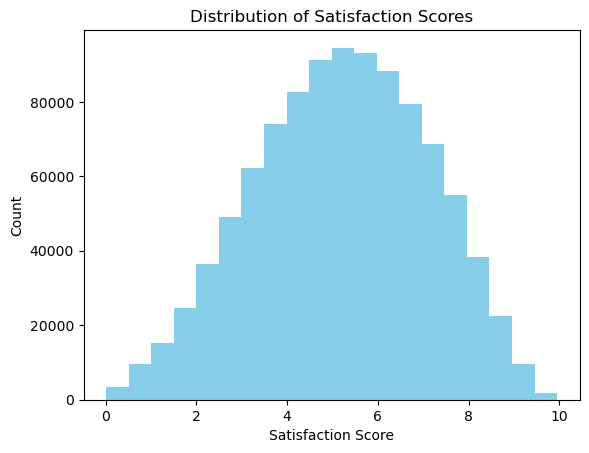

In [ ]:
import matplotlib.pyplot as plt

# Distribution of satisfaction scores
plt.hist(merged_df['satisfaction_score'], bins=20, color='skyblue')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.show()

# 	The model generates varied and realistic scores, not just extremes. Few matches are extremely poor or perfect — as expected. Most user–portfolio combos are "okay but not great" — also realistic
